In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from scipy import stats
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.models import GP
from jaxbo.utils import normalize

import jaxbo.acquisitions as acquisitions
import jaxbo.utils as utils
from jaxbo.input_priors import uniform_prior

from sklearn import mixture
from pyDOE import lhs

onp.random.seed(1234)


In [2]:
def Michalewicz_function(x, y):
    m = 10.0
    # The one that you are multiplying on the first terms in x^2 and y^2 actually controls 
    # the number of modes in this direction
    z = np.sin(x) * np.sin( (2) * x**2 / np.pi )**(2*m) + np.sin(y) * np.sin( (3) * y**2 / np.pi )**(2*m)
        
    return -z



In [3]:
class run_simulations:
    # Initialize the class
    def __init__(self, data_test, xs_in, sigma_in, T_in, MC_samples_in, XX, YY, Y_data_plot, nn):
        
        # Initialize the model
        self.Data = data_test
        self.N_dim = self.Data.shape[0]
        
        self.xs = xs_in
        self.sigma = sigma_in
        self.T = T_in
        self.MC_samples = MC_samples_in
        self.delta = 0.1
        self.jitter = 1e-8
        self.N_init = 3
        
        self.XX = XX
        self.YY = YY
        self.Y_data_plot = Y_data_plot
        self.nn = nn
        
        # define GP model and JAX GP options
        self.dim = xs_in.shape[1]
        self.lb = 0.0*np.ones(self.dim)
        self.ub = 1.0*np.ones(self.dim)
        self.bounds = {'lb': self.lb, 'ub': self.ub}
        self.p_x = uniform_prior(self.lb, self.ub)
        self.options = {'kernel': 'RBF', 'input_prior': self.p_x}
        self.gp_model = GP(self.options)
        
        self.rng_key = random.PRNGKey(0)
        
        
    # Different types of acquisition functions
    def acquisition_functions(self, mu, std, y_sample, best, beta = 1.0, weights = 0, method = "LCB"):
        kappa = 2.0
        if method == "LCB":
            return vmap(acquisitions.LCB, in_axes=(0,0,None))(mu[:,None], std[:,None], np.sqrt(beta))
        if method == "LCB_v":
            return vmap(acquisitions.LCB, in_axes=(0,0,None))(mu[:,None], std[:,None], kappa)
        if method == "mean":
            return mu
        if method == "LW_LCB":
            return vmap(acquisitions.LW_LCB, in_axes=(0,0,0,None))(mu[:,None], std[:,None], weights[:,None], kappa)
        if method == "TS":
            return y_sample
        if method == "EI":
            return vmap(acquisitions.EI, in_axes=(0,0,None))(mu[:,None], std[:,None], best)
    
    
    def compute_weights(self, x):
        
        weights = utils.compute_w_gmm(x, **self.kwargs)
        self.weights = weights
        
        return weights
        
    def compute_beta(self, t):
        beta = 2 * np.log(t**2*np.pi**2/(6 * self.delta))
        beta = beta / 5.
        return beta

    def compute_mu_std_sample(self, X, y, X_star, rng_key, compute_weight = False):
        
        # Fetch normalized training data
        norm_batch, norm_const = normalize(X, y, self.bounds)

        # Train GP model
        opt_params = self.gp_model.train(norm_batch, rng_key, num_restarts = 10)
        
        # Define the dictionary to feed in the GP regression 
        self.kwargs = {'params': opt_params, 
                  'batch': norm_batch, 
                  'norm_const': norm_const, 
                  'bounds': self.bounds,
                  'rng_key': rng_key}
        
        if compute_weight:
            gmm_vars = self.gp_model.fit_gmm(**self.kwargs, num_comp = 4, N_samples = 10000)

            self.kwargs = {'params': opt_params,
                  'batch': norm_batch,
                  'norm_const': norm_const,
                  'bounds': self.bounds,
                  'gmm_vars': gmm_vars,
                  'rng_key': rng_key}

        # Draw posterior mean and std and a sample from posterior distribution 
        mu, std = self.gp_model.predict(X_star, **self.kwargs)
        y_sample = self.gp_model.draw_posterior_sample(X_star, **self.kwargs)
        
        mu, std = mu * norm_const['sigma_y'] + norm_const['mu_y'], std *norm_const['sigma_y']
        y_sample = y_sample * norm_const['sigma_y'] + norm_const['mu_y']
        
        return mu, std, y_sample
        
        
    def run_one_trial(self, sample_idx, method = "LCB"):
        
        # the testing data for the current MC trial
        data = self.Data[:,sample_idx]
        x_cand = self.xs
        
        # inital random observation
        idx_init = onp.random.randint(self.N_dim, size = self.N_init) #[np.random.randint(self.N_dim)]
        
        # check the shape (Y is vector not array)
        Y = data[idx_init]
        X = x_cand[idx_init,:]
        
        regrets = []
        
        # get the best payoff
        index_best = np.argmin(data)
        Y_best = data[index_best]
        
        # start to record the regret
        regrets.append(abs(Y_best - np.min(Y)))
        
        rng_key = random.split(self.rng_key)[0]
        # start the active learning
        for t in range(1, self.T):

            # compute beta and modify correspondingly according to inital number of data
            beta = self.compute_beta(t + self.N_init - 1)
            
            #print("X, Y", X.shape, Y.shape, X, Y)
            
            if method == "LW_LCB":
                compute_weight = True
            else:
                compute_weight = False
            
            # compute GP posterior mean and std
            rng_key = random.split(rng_key)[0]
            mu, std, y_sample = self.compute_mu_std_sample(X, Y, self.xs, rng_key, compute_weight)
            
            # best for the EI if needed
            best = np.min(Y)
            
            # compute the weight for the LW-LCB if needed
            if method == "LW_LCB":
                weights = self.compute_weights(x_cand)
            else:
                weights = 0
                
            # compute acquisition function
            acquisition_fun = self.acquisition_functions(mu, std, y_sample, best, beta, weights, method)

            # find the index best location to explore 
            best_index = np.argmin(acquisition_fun)
            
            # find the best location to explore
            X_new = x_cand[best_index:best_index+1,:]
            
            # observe the noisy reward
            Y_new = data[best_index] + onp.random.normal(0, self.sigma, 1)
            
            #print(X.shape, Y.shape, X_new.shape, Y_new.shape)
            # update X and Y
            X = np.concatenate([X, X_new], axis = 0)
            Y = np.concatenate([Y, Y_new], axis = 0)
            
            regrets.append(abs(Y_best - Y_new[0]))
            #regrets.append(abs(Y_best - min(Y)))
            
            if t == self.T - 1 and method == "LW_LCB":
                
                weights_plot = np.reshape(weights, (self.nn, self.nn))
                
                plt.figure(t + sample_idx, figsize = (7, 7))
                plt.subplot(1, 2, 1)
                fig = plt.contourf(self.XX, self.YY, self.Y_data_plot)
                plt.plot(X[:,0], X[:,1], 'r.', ms = 6, alpha = 0.8)
                plt.xlabel(r'$x_1$')
                plt.ylabel(r'$x_2$')
                plt.axis('square')
                
                plt.subplot(1, 2, 2)
                fig = plt.contourf(self.XX, self.YY, weights_plot)
                plt.plot(X[:,0], X[:,1], 'r.', ms = 6, alpha = 0.8)
                plt.xlabel(r'$x_1$')
                plt.ylabel(r'$x_2$')
                plt.axis('square')
                plt.show()
            
            if method == "LW_LCB":
                continue
            else:
                weights_plot = None
            
        return regrets, X, weights_plot
        
    def train(self):
        
        regrets_LCB = []
        regrets_LCB_v = []
        regrets_mean = []
        regrets_TS = []
        regrets_EI = []
        regrets_LW_LCB = []
        
        X_LCB = []
        X_LCB_v = []
        X_mean = []
        X_TS = []
        X_EI = []
        X_LW_LCB = []
        
        Weights_LW_LCB = []


        for k in range(self.MC_samples):
            if k % 1 == 0:
                print(k)
            regrets, X, weights_plot = self.run_one_trial(k, method = "LW_LCB")
            regrets_LW_LCB.append(regrets)
            X_LW_LCB.append(X)
            Weights_LW_LCB.append(weights_plot)
            regrets, X, _ = self.run_one_trial(k, method = "LCB")
            regrets_LCB.append(regrets)
            X_LCB.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "LCB_v")
            regrets_LCB_v.append(regrets)
            X_LCB_v.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "mean")
            regrets_mean.append(regrets)
            X_mean.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "TS")
            regrets_TS.append(regrets)
            X_TS.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "EI")
            regrets_EI.append(regrets)
            X_EI.append(X)

            
            
        regrets_LCB = np.asarray(regrets_LCB)
        regrets_LCB_v = np.asarray(regrets_LCB_v)
        regrets_mean = np.asarray(regrets_mean)
        regrets_TS = np.asarray(regrets_TS)
        regrets_EI = np.asarray(regrets_EI)
        regrets_LW_LCB = np.asarray(regrets_LW_LCB)
        
        X_LCB = np.asarray(X_LCB)
        X_LCB_v = np.asarray(X_LCB_v)
        X_mean = np.asarray(X_mean)
        X_TS = np.asarray(X_TS)
        X_EI = np.asarray(X_EI)
        X_LW_LCB = np.asarray(X_LW_LCB)
        
        Weights_LW_LCB = np.asarray(Weights_LW_LCB)
        
        print(regrets_LCB.shape, regrets_LCB_v.shape, regrets_mean.shape, regrets_TS.shape, regrets_EI.shape, regrets_LW_LCB.shape, \
                X_LCB.shape, X_LCB_v.shape, X_mean.shape, X_TS.shape, X_EI.shape, X_LW_LCB.shape, Weights_LW_LCB.shape)
        
        return regrets_LCB, regrets_LCB_v, regrets_mean, regrets_TS, regrets_EI, regrets_LW_LCB, \
                X_LCB, X_LCB_v, X_mean, X_TS, X_EI, X_LW_LCB, Weights_LW_LCB
            




(2500, 100)


(0.0, 1.0, 0.0, 1.0)

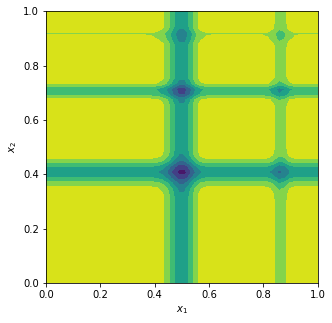

In [4]:
MC_samples = 100
nn = 50

# Locations for bandits
xx = np.linspace(0, 1, nn)
yy = np.linspace(0, 1, nn)
XX, YY = np.meshgrid(xx, yy)
X_positions = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)

# Draw training data from functions
Y_data = Michalewicz_function((X_positions[:,0]) * np.pi, (X_positions[:,1]) * np.pi)[:,None]

# Normalize the data
Y_data = (Y_data - np.mean(Y_data)) / np.std(Y_data)

Y_data = np.tile(Y_data,(1, MC_samples))
Y_data = Y_data
print(Y_data.shape)


xs = X_positions

sigma = np.sqrt(1e-8) 
T = 150

# Plot the first snapshot as the data
Y_data_plot = np.reshape(Y_data[:,0], (nn, nn))

plt.figure(-2, figsize = (5, 5))
fig = plt.contourf(XX, YY, Y_data_plot)
#plt.plot(X_positions[:,0], X_positions[:,1], 'r.', ms = 6, alpha = 0.8)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.axis('square')


0


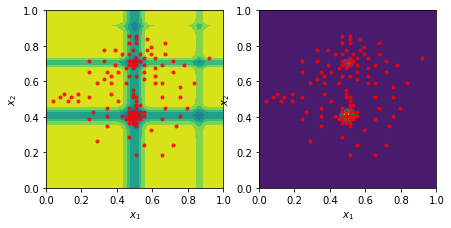

1


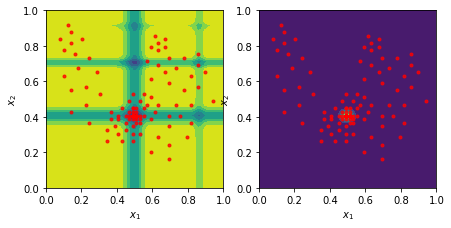

2


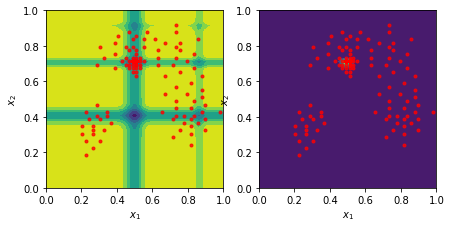

3


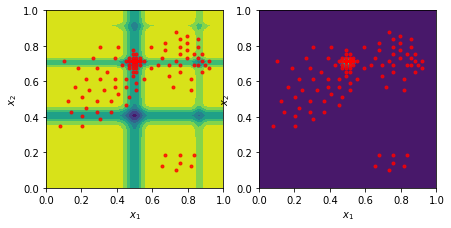

4


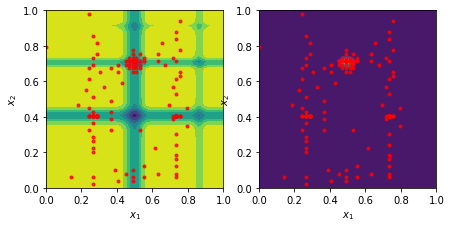

5


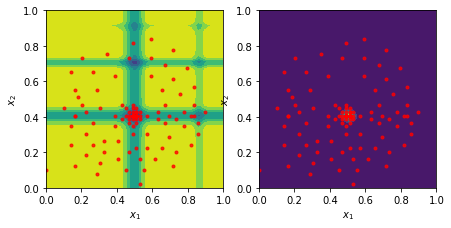

6


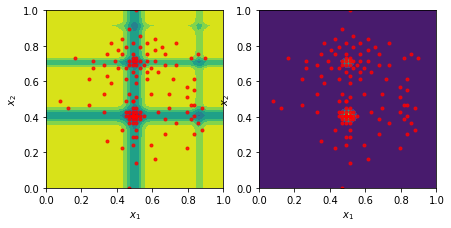

7


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


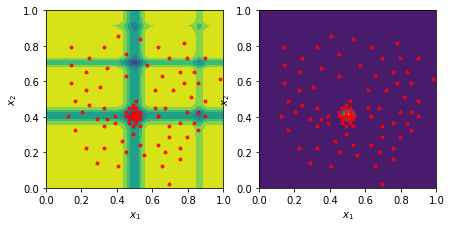

8


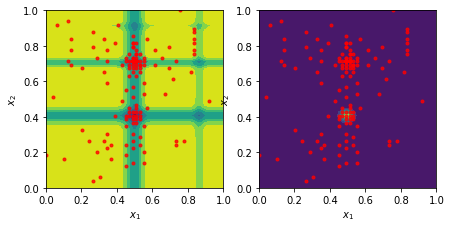

9


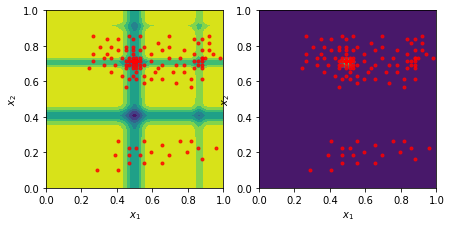

10


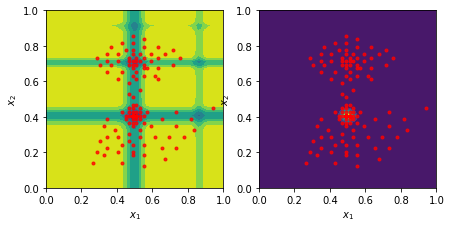

11


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


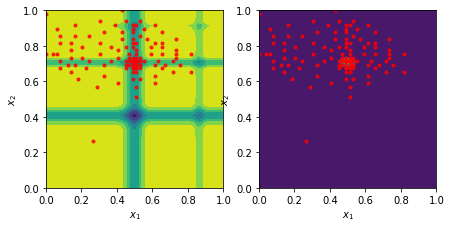

12


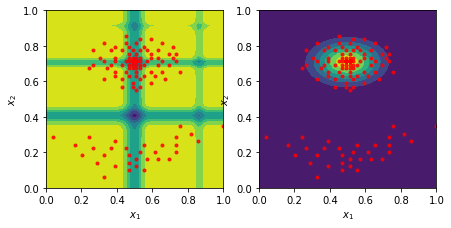

13


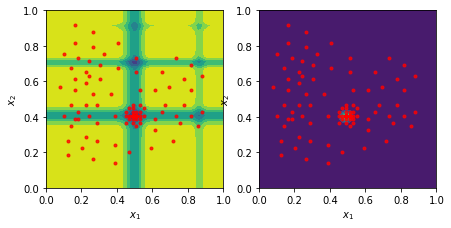

14


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


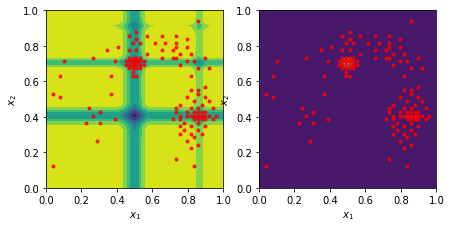

15


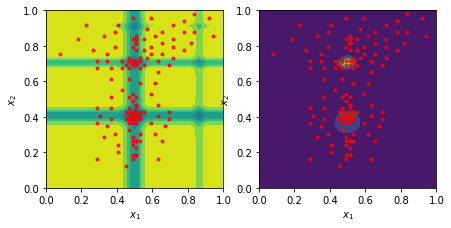

16


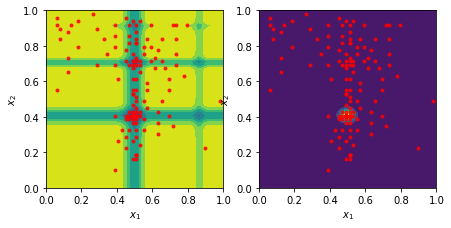

17


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


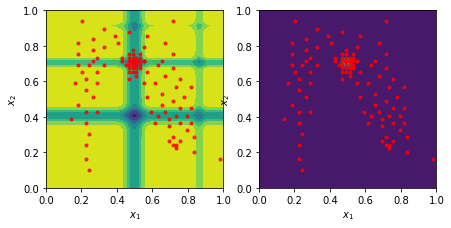

18


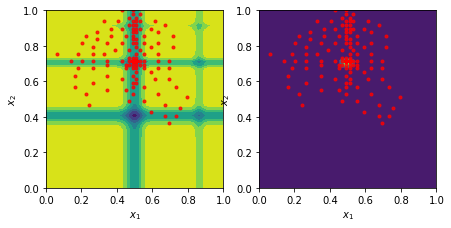

19


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


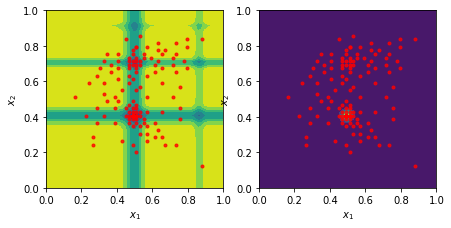

20


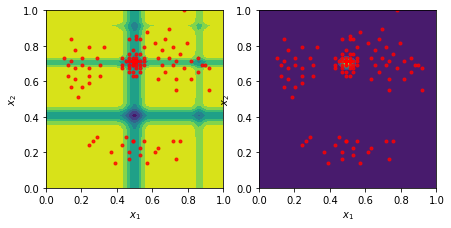

21


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


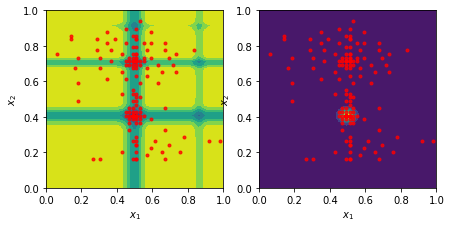

22


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


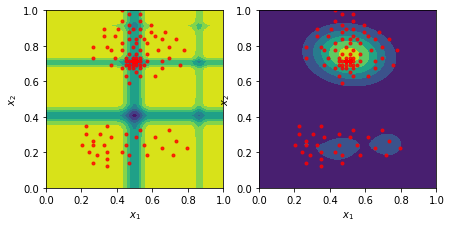

23


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


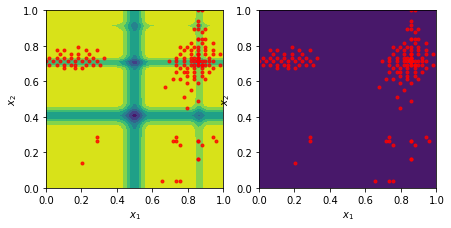

24


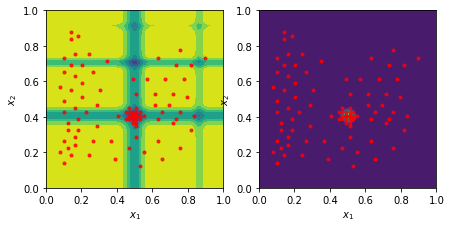

25


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


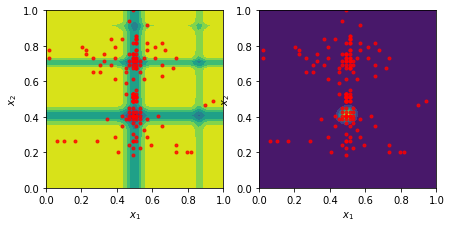

26


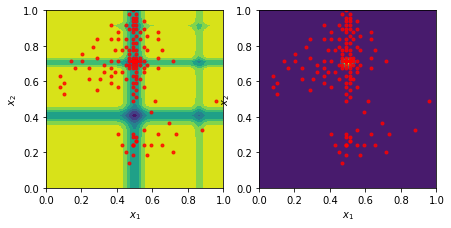

27


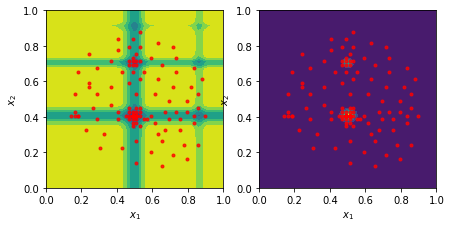

28


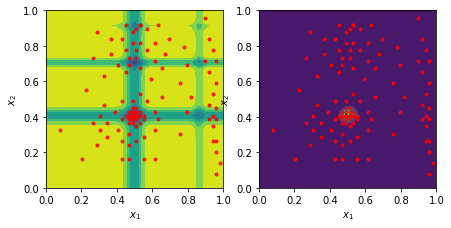

29


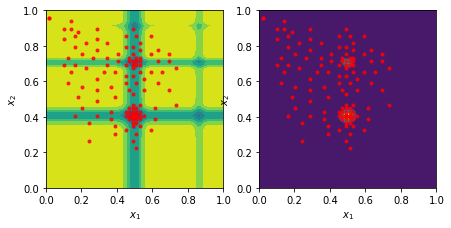

30


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


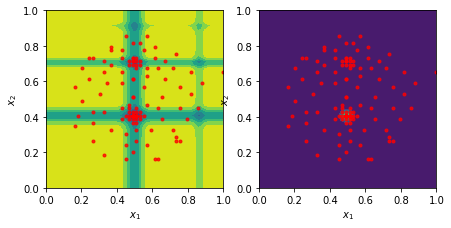

31


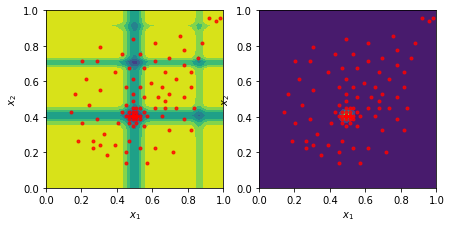

32


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


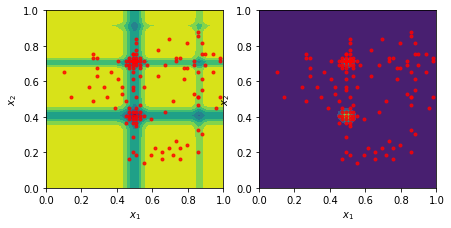

33


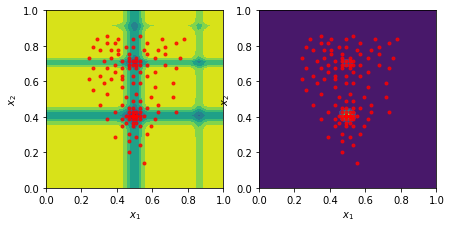

34


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


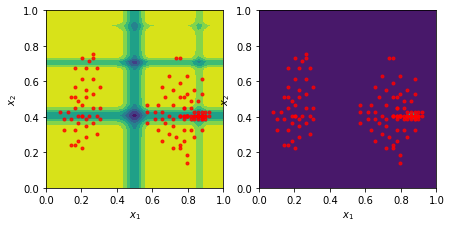

35


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


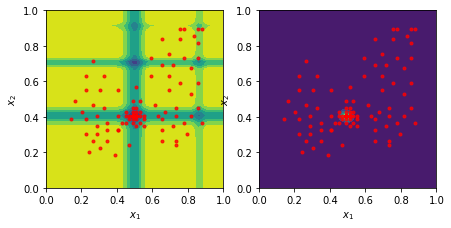

36


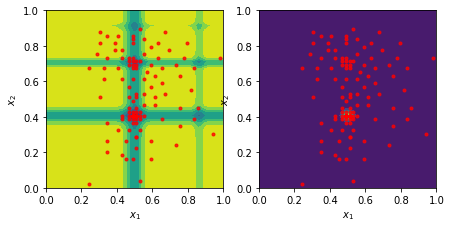

37


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


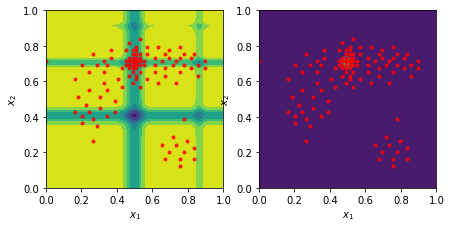

38


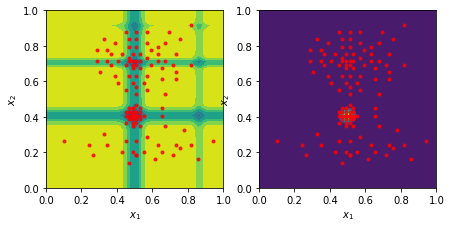

39


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


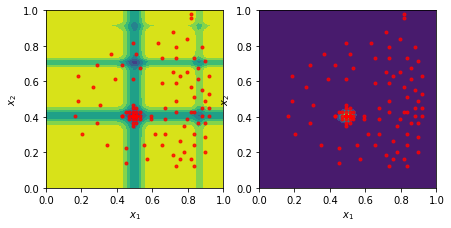

40


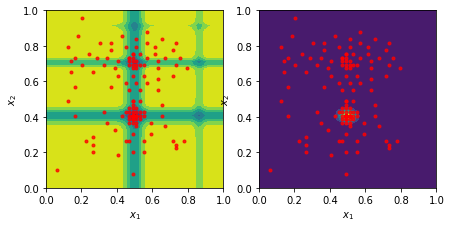

41


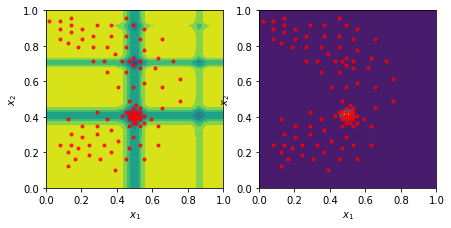

42


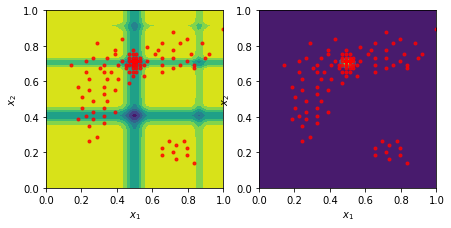

43


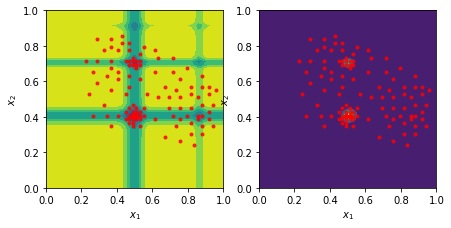

44


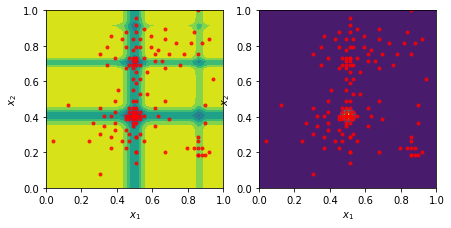

45


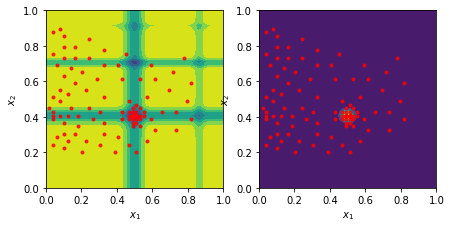

46


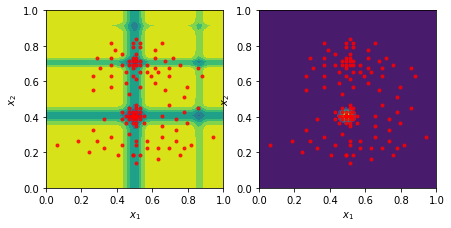

47


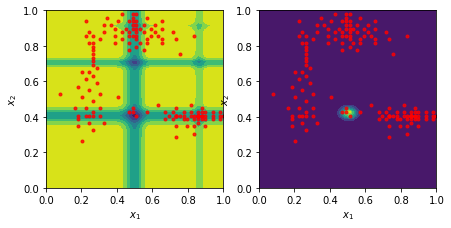

48


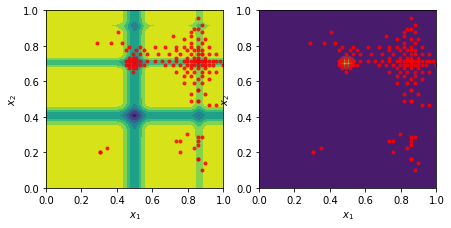

49


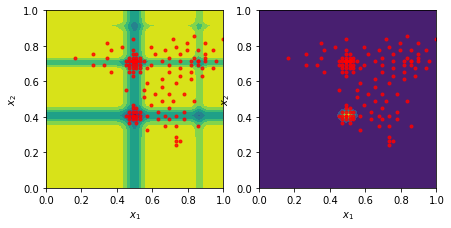

50


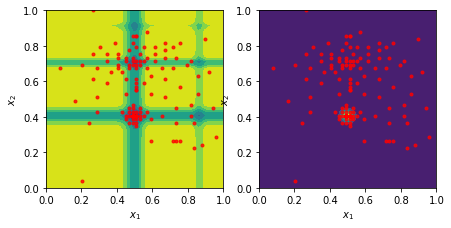

51


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


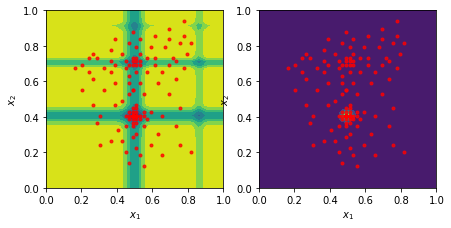

52


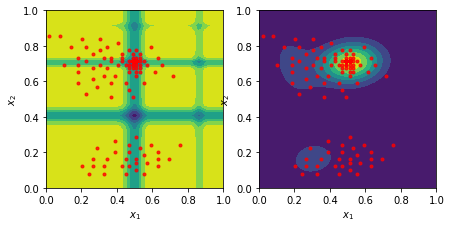

53


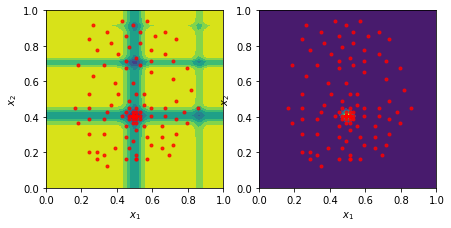

54


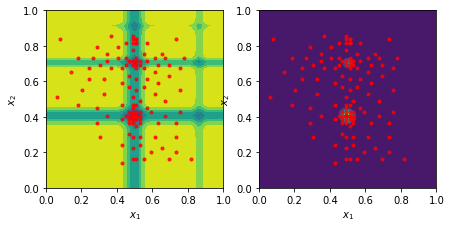

55


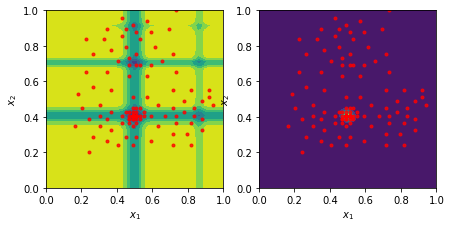

56


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


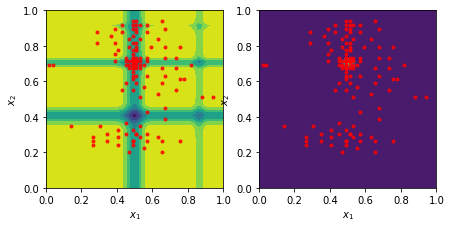

57


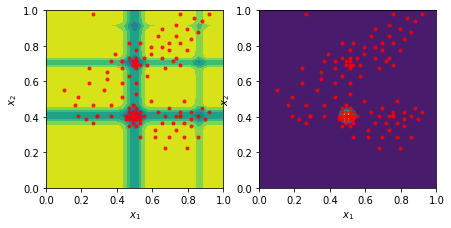

58


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


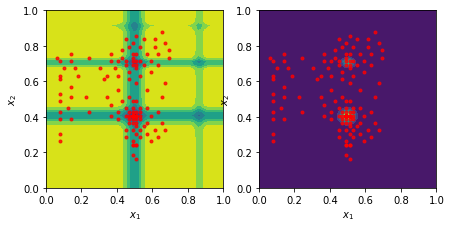

59


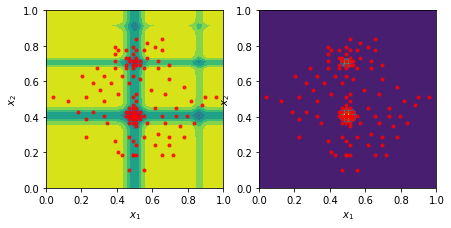

60


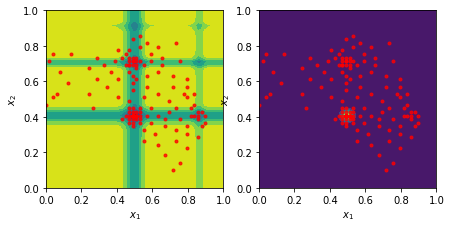

61


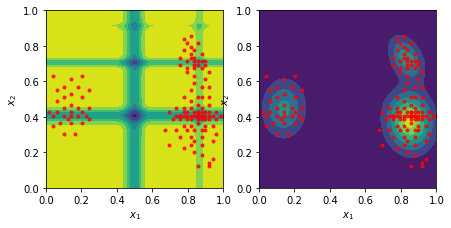

62


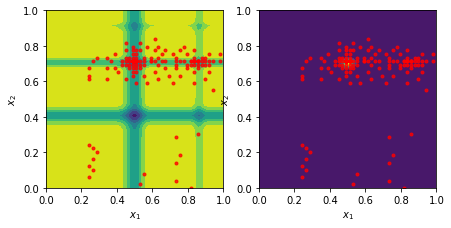

63


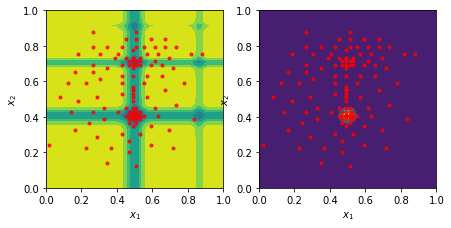

64


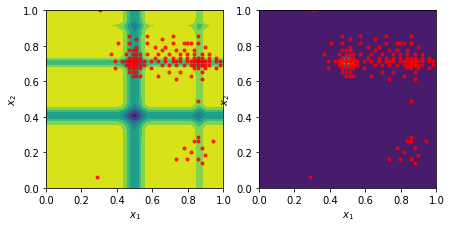

65


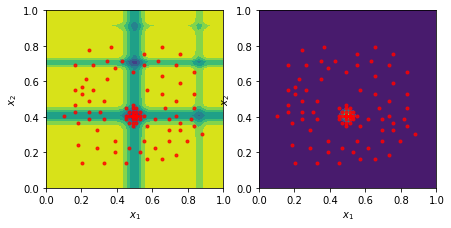

66


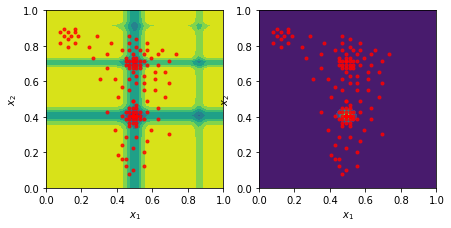

67


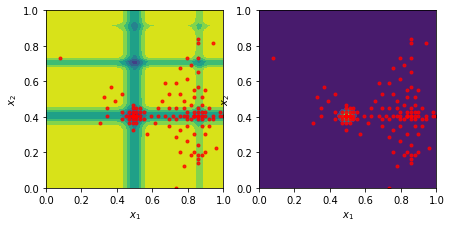

68


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


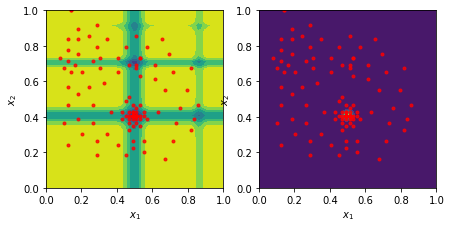

69


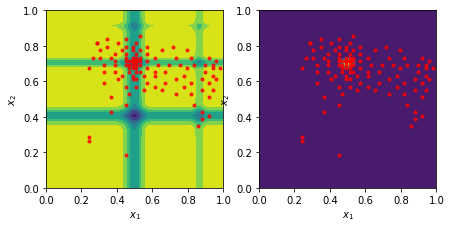

70


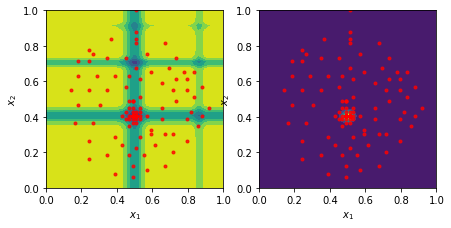

71


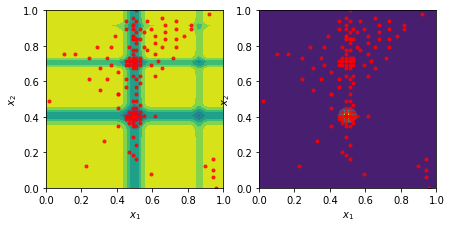

72


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


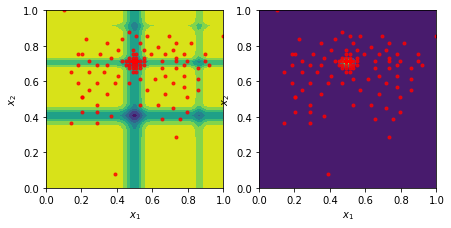

73


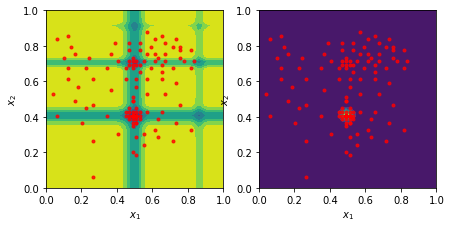

74


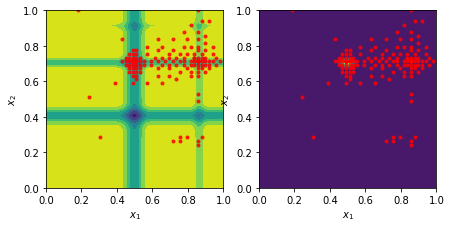

75


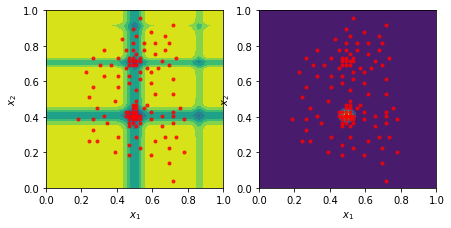

76


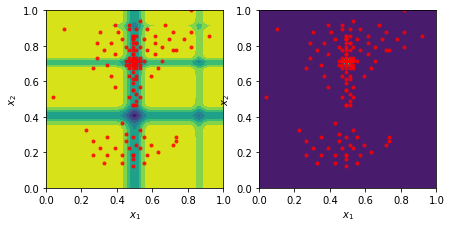

77


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


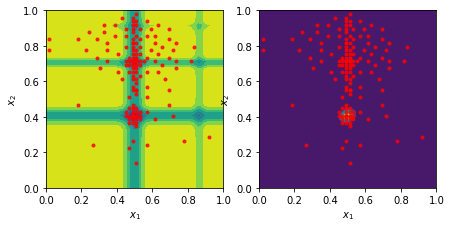

78


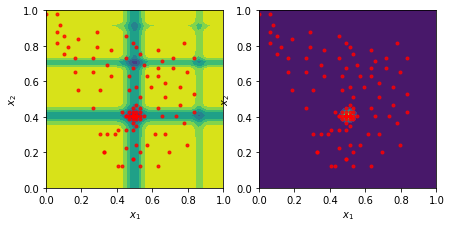

79


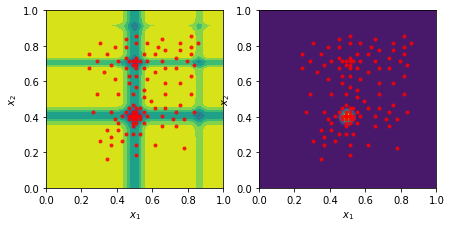

80


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


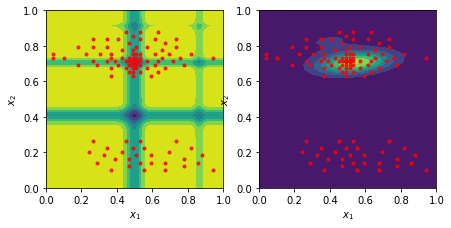

81


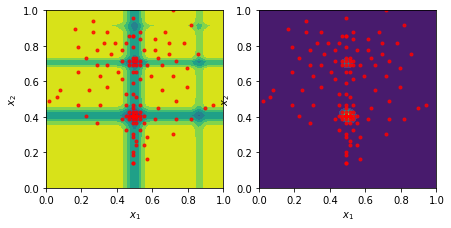

82


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


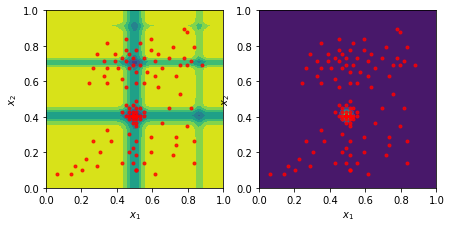

83


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


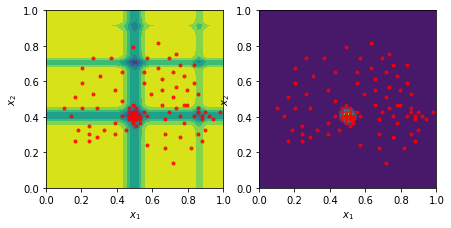

84


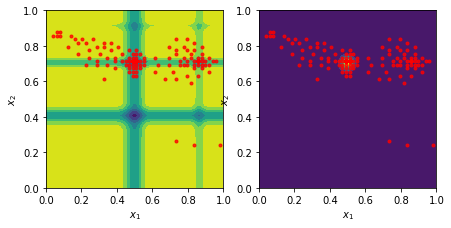

85


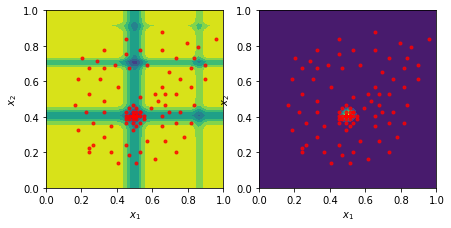

86


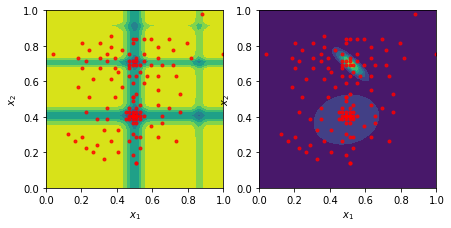

87


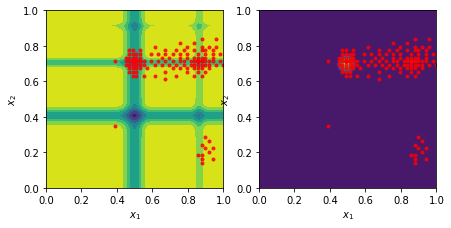

88


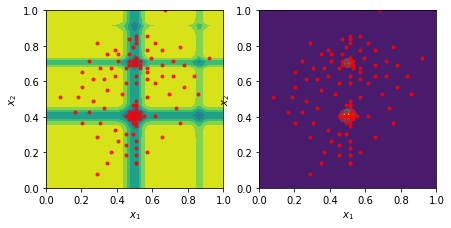

89


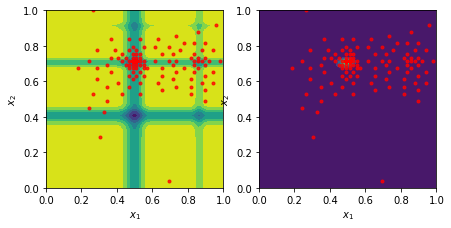

90


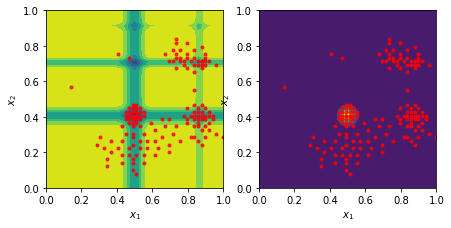

91


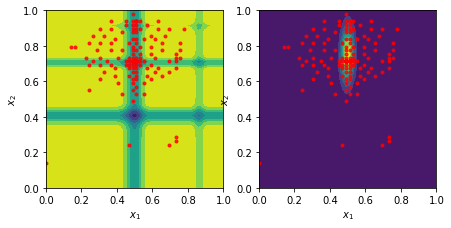

92


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


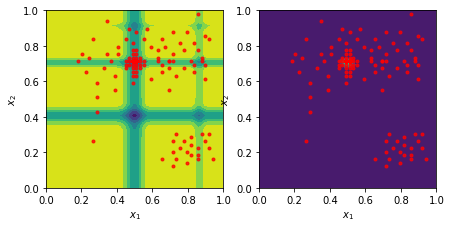

93


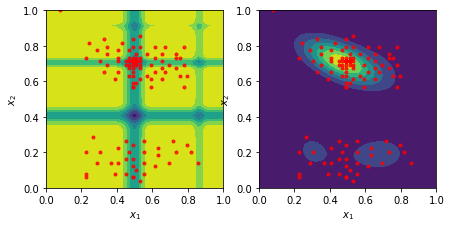

94


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


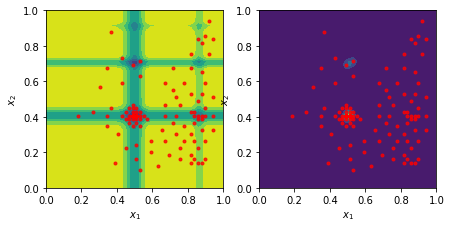

95


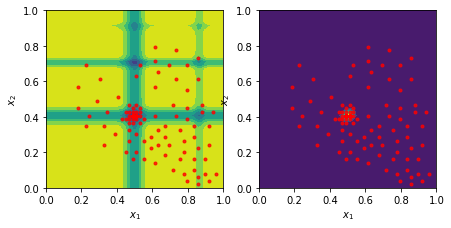

96


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


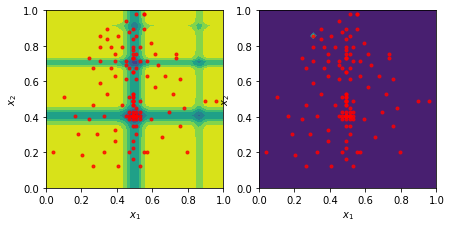

97


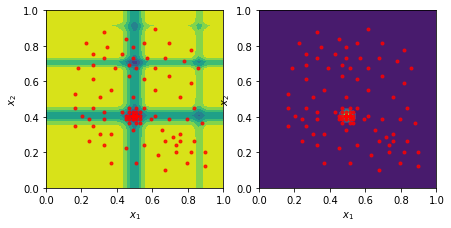

98


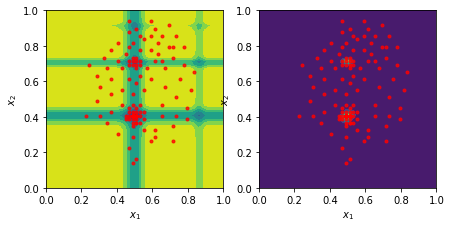

99


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


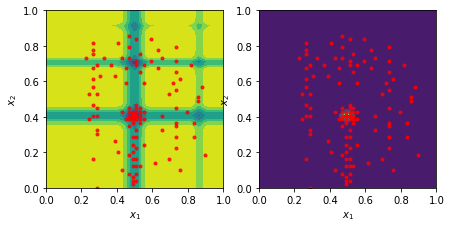

(100, 150) (100, 150) (100, 150) (100, 150) (100, 150) (100, 150) (100, 152, 2) (100, 152, 2) (100, 152, 2) (100, 152, 2) (100, 152, 2) (100, 152, 2) (100, 50, 50)


In [5]:
model = run_simulations(Y_data, xs, sigma, T, MC_samples, XX, YY, Y_data_plot, nn)
regrets_LCB, regrets_LCB_v, regrets_mean, regrets_TS, regrets_EI, regrets_LW_LCB, \
X_LCB, X_LCB_v, X_mean, X_TS, X_EI, X_LW_LCB, Weights_LW_LCB = model.train()

np.save("regrets_LCB", regrets_LCB)
np.save("regrets_LCB_v", regrets_LCB_v)
np.save("regrets_mean", regrets_mean)
np.save("regrets_TS", regrets_TS)
np.save("regrets_EI", regrets_EI)
np.save("regrets_LW_LCB", regrets_LW_LCB)

np.save("X_LCB", X_LCB)
np.save("X_LCB_v", X_LCB_v)
np.save("X_mean", X_mean)
np.save("X_TS", X_TS)
np.save("X_EI", X_EI)
np.save("X_LW_LCB", X_LW_LCB)

np.save("Weights_LW_LCB", Weights_LW_LCB)


